# Optuna
- Optuna is a great tool for exploring the hyper-parameters of an optimisation problem. 
- It is versatile because it is lightweight and specialised - a feature commonly lost in big projects. 
- Optuna comes in handy for DL since we do have a lot of hyper-params of varying sensitivity.
- Here I will write some recipies for Pytorch training with Optuna and then for a single-node multi-gpu setup.

### 1. Optuna and Pytorch
- The official examples intertwine Optuna calls with Pytorch trainer boilerplate.
- Ideally one would decouple this things so one can run DL training independently (for POC, or debugging) and then add Optuna on top if necessary.
- For this I will try to split the Pytorch parts from the Optuna calls by encapsulation.

### 2. Single-node multi-GPU
- Parallel training of models in a multi-GPU setting is very useful for small datasets/models.
- Parallel training in Optuna is possible since the db is safe of race conditions.
- We can spawn multiple workers/processes and assign it a separate GPU.

In [20]:
import sys
import joblib
import logging
import subprocess

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR100
from torchvision.models import vgg16_bn

import optuna
from optuna import Trial
from optuna import visualization as opt_viz

%config Completer.use_jedi = False
%matplotlib inline

# 1. Optuna and Pytorch
- Pytorch boilerplate code such as getting the data loaders, computing accuracy, creating the model etc.
- Ideally the Pytorch trainer would not depend on Optuna so it can be run independently.
- Only once we are happy with the trainer we would wish to pass it to Optuna.

## 1.1 Pytorch Trainer
- The trainer should receive it's hyper-params directly as args, not as a trial
- Will yield the optuna objective metric (accuracy here) since we need to report it to the trial object for pruning
- Turning the trainer into a generator allows us to decouple it from Optuna entirely

In [15]:
DS_PATH = "/data/datasets/CIFAR100"


def get_model():
    model = vgg16_bn()
    model.features = model.features[:-1]
    model.avgpool = nn.AvgPool2d(kernel_size=2)
    model.classifier = nn.Sequential(nn.Linear(512, 100))
    return model


def get_accuracy(model, loader):
    correct = 0
    n_obs = 0

    device = list(model.parameters())[0].device
    model.eval()
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            out = model(X)
        correct += (out.argmax(dim=1) == y).float().sum()
        n_obs += len(X)
    model.train()

    accuracy = correct / n_obs
    return accuracy.item()


def get_loaders(batch_size=64):
    means = [0.5071, 0.4867, 0.4408]
    stds = [0.2675, 0.2565, 0.2761]
    
    train_transform = transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(means, stds),
        ]
    )
    test_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(means, stds),
        ]
    )

    train_ds = CIFAR100(root=DS_PATH, transform=train_transform, train=True)
    test_ds = CIFAR100(root=DS_PATH, transform=test_transform, train=False)

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True, pin_memory=True
    )
    test_loader = DataLoader(
        test_ds, batch_size=batch_size, shuffle=False, pin_memory=True
    )

    return train_loader, test_loader
    


def train(n_epochs=10, batch_size=64, lr=1e-1, device="cuda:0"):
    """
    Trying to keep any optuna code out of here, keep just a standard pytorch training.
    Need to make it a generator to yield the objective score.
    """
    model = get_model().to(device)
    train_loader, test_loader = get_loaders(batch_size)
    
    criterion = nn.CrossEntropyLoss()
    optimiser = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4, nesterov=True)
    lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimiser, T_max=n_epochs)
    
    for epoch in range(n_epochs):
        
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            criterion(model(X), y).backward()
            optimiser.step()
            optimiser.zero_grad()
            
        lr_scheduler.step()
        acc = get_accuracy(model, test_loader)
        yield acc


## 1.2 Optuna
- Will encapsulate the pytorch boilerplate.
- Optuna calls will be reduced to run_trial and run_study.
- run_trial will be the "objective" function from standard Optuna tutorials, accepting the trial parameter.
- Ideally the hyper-parameter ranges should be defined outside and run_trials should accept them as args.
- run_study will make run_trial partial by assigning the hyper-param ranges, Optuna needs run_trial to just get trial.

In [47]:
def run_trial(trial: Trial, n_epochs="10:50:10", batch_size="50:1000:50", lr="1e-4:1e-1:1e-4", device="cuda:0"):
    """
    Would have been nice to be able to specify hyper-param ranges when creating the study rather than in the trial.
    Workaround by passing string args and parsing them here. Will call this function as a curry/partial.
    """
    parse_arg = lambda arg, type_: {key: type_(val) for key, val in zip(["low", "high", "step"], arg.split(":"))}
    
    n_epochs = trial.suggest_int("n_epochs", **parse_arg(n_epochs, int))
    batch_size = trial.suggest_int("batch_size", **parse_arg(batch_size, int))
    lr = trial.suggest_float("lr", **parse_arg(lr, float))
    
    for epoch, acc in enumerate(train(n_epochs=n_epochs, batch_size=batch_size, lr=lr, device=device)):
        trial.report(acc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return acc


def run_study(study_name=None, n_trials=20, **trial_kwargs):
    """
    Creates, launches and returns the study. 
    Trial hyper-param ranges passed as kwarg-slicing-string-style-whatever e.g n_epochs="low:high:step"
    """
    study = optuna.create_study(
        study_name=study_name, 
        load_if_exists=True, 
        storage="sqlite:///example.db",
        pruner=optuna.pruners.HyperbandPruner(), 
        direction="maximize"
    )
    study.optimize(lambda trial: run_trial(trial, **trial_kwargs), n_trials=n_trials)
    return study

In [ ]:
study = run_study(n_trials=20, n_epochs="10:50:10", batch_size="50:1000:50", lr="1e-4:1e-1:1e-4")

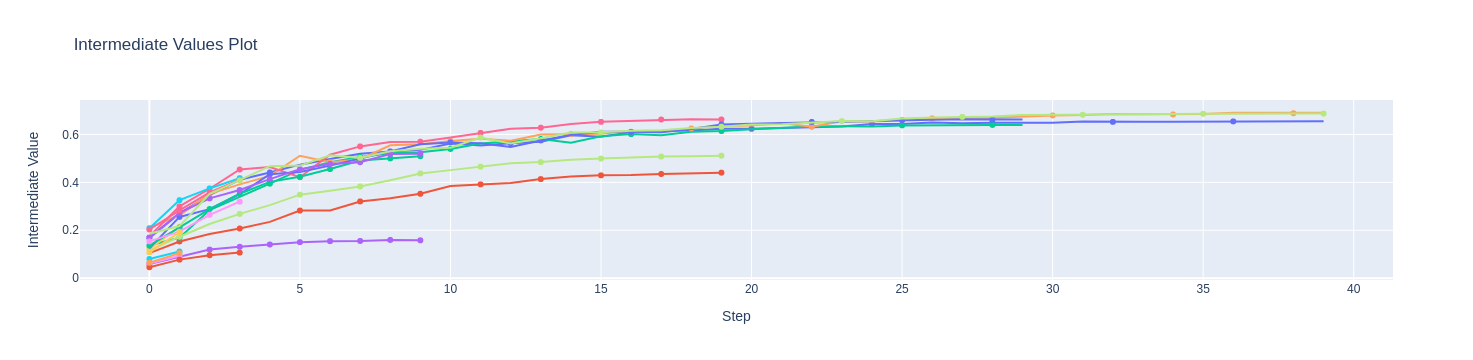

In [7]:
opt_viz.plot_intermediate_values(study)

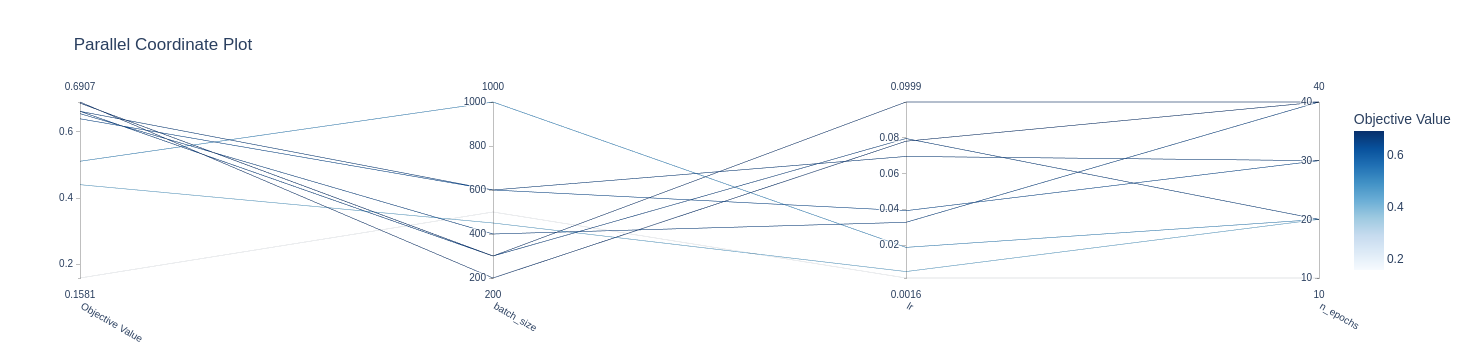

In [6]:
opt_viz.plot_parallel_coordinate(study)

# 2. Single-node Multi-GPU 
- Run each trial on a separate GPU on the same machine.
- Parallelise training such that every trial/GPU is a different process.
- Optuna makes things easy since it stores results in a db, making it safe for processes to read/write.
- Each process will be a worker with a dedicated GPU. It will parallel run the study and communicating to the db.

In [57]:
def gpu_count() -> int:
    """Get the number of gpus"""
    res = subprocess.check_output(["nvidia-smi", "--list-gpus"]).decode().split("\n")
    res = len(res) - 1  # last \n dont count
    return res


def run_parallel_study(study_name: str=None, n_trials: int=20, **kwargs):
    study = optuna.create_study(
        study_name=study_name, 
        storage="sqlite:///example.db",
        pruner=optuna.pruners.HyperbandPruner(), 
        direction="maximize"
    )
    
    n_gpus = gpu_count()
    parallel = joblib.Parallel(n_jobs=n_gpus)
    parallel([joblib.delayed(run_study)(study_name=study.study_name, n_trials=n_trials//n_gpus, device=f"cuda:{i}", **kwargs) for i in range(n_gpus)])
    return study

In [58]:
study = run_parallel_study(n_trials=50, n_epochs="20:200:10", batch_size="50:1000:50", lr="1e-4:1e-1:1e-4")

[I 2022-05-04 18:20:19,154] A new study created in RDB with name: no-name-bf041c59-0959-4ec0-b41f-4fe81ec6572f


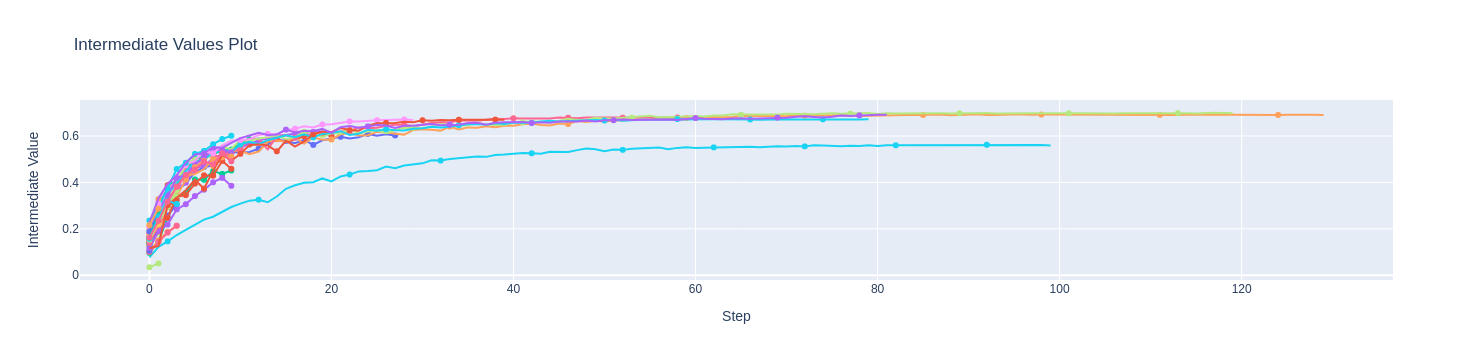

In [60]:
opt_viz.plot_intermediate_values(study)

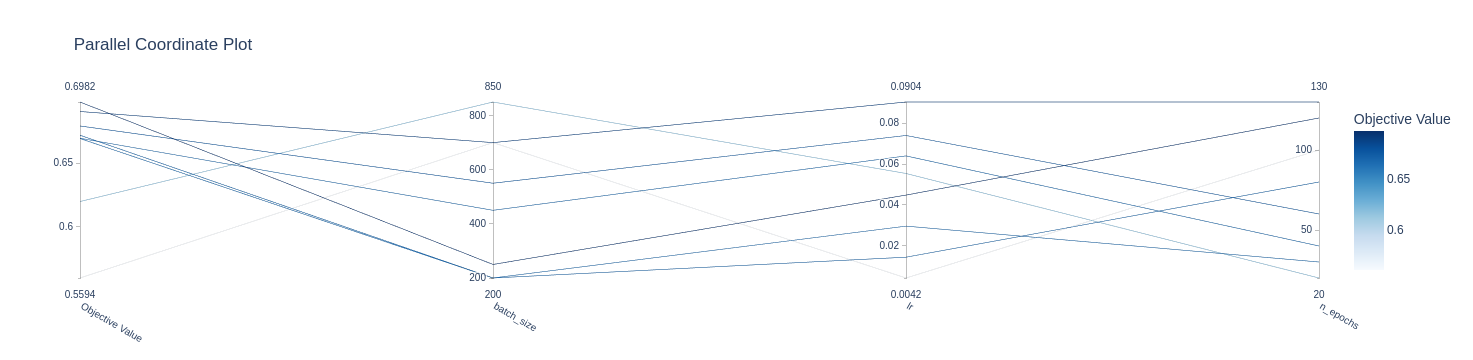

In [61]:
opt_viz.plot_parallel_coordinate(study)